## Comparing Agents List:

###### 1. Single Action Agent
Always returns the same action / product id.

###### 2. Random Action Agent
The Agent returns the random action from all of product id's range.

###### 3. Organic Product Count Agent
The Agent that selects an action based on the most frequently viewed Product.

###### 4. Organic Per User Count Agent
The Agent that counts organic views of products per a user and selects an action for the most frequently shown product.

###### 5. Define Organic MF Agent
The Agent that selects an action from the model that performs Organic Events matrix factorisation.

###### 6. Bandit Click Count Agent
The Agent that selects an Action for the most frequently clicked bandit action before.

###### 7. Bandit MF Agent - used Matrix Factorization learning model
The Agent chooses maximum logit (logistic regression) from all possible actions.

###### 8. Likelihood Agent
Act method returns an action based on current observation and past history.

## Environment Setup

In [1]:
from copy import deepcopy

import recogym
from my_agent_utils import add_agent_id, combine_stat
from my_entries.likehood_agent import LikelihoodAgent, CountFeatureProvider
from single_action_agent import SingleActionAgent
%matplotlib inline
import gym
import matplotlib.pyplot as plt

from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args, OrganicCount, organic_count_args, \
    OrganicMFSquare, organic_mf_square_args, BanditCount, bandit_count_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import plot_verify_agents

# Set style for pretty plots
plt.style.use('ggplot')

products = 100

offline_users = 5400
online_users = 500

# You can overwrite environment arguments here:

env_1_args['random_seed'] = 42
env_1_args['num_products']= products
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=1

# env_1_args['sigma_mu_organic'] = 0.0
# env_1_args['sigma_omega']=0
# env_1_args['normalize_beta']=True

# Initialize the gym for the first time by calling .make() and .init_gym()

#---------------------------------------------
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

env_1_args['number_of_flips'] = 0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega'] = 1
env_1_args['random_seed'] = 42
env_1_args['num_products'] = products
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 5
#---------------------------------------------

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()


/workspace/ML/reco-gym/recogym/envs/abstract.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


1. Define Single Action Agent

In [2]:
single_action_agent = SingleActionAgent(Configuration({**env_1_args,}))

SingleActionAgent %%%% num_products: 100


2. Define Random Action Agent

In [3]:
random_agent = RandomAgent(Configuration({**random_args,**env_1_args,}))

RandomAgent %%%% num_products: 100


3. Define Organic Product Count Agent

In [4]:
organic_count_agent = OrganicCount(Configuration({**organic_count_args,**env_1_args,}))

4. Define Organic Per User Count Agent

In [5]:
organic_user_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args, **env_1_args, 'select_randomly': True,}))

5. Define Organic MF Agent

In [6]:
organic_mf_agent = OrganicMFSquare(Configuration({**organic_mf_square_args, **env_1_args, 'select_randomly': True,}))

6. Define Bandit Click Count Agent

In [7]:
bandit_count_agent = BanditCount(Configuration({**bandit_count_args,**env_1_args,}))

BanditCount %%%% num_products: 100


7. Define Bandit MF Agent

In [8]:
bandit_mf_square_agent = BanditMFSquare(Configuration({ **bandit_mf_square_args, **env_1_args,}))

8. Define Likelihood Agent

In [9]:
# from scipy.stats import beta
# import pandas as pd
#
# config = Configuration(env_1_args)
#
# count_product_views_feature_provider = CountFeatureProvider(config)
#
# likelihood_agent = LikelihoodAgent(count_product_views_feature_provider)
#
# lh_data = deepcopy(env).generate_logs(offline_users)
#
# likelihood_agent.train_from_logs(lh_data)
#
# bandits = lh_data[lh_data['z'] == 'bandit']
# successes = bandits[bandits['c'] == 1].shape[0]
# failures = bandits[bandits['c'] == 0].shape[0]
#
# lh_agent_res = add_agent_id(
#     'Likelihood',
#     beta.ppf(0.025, successes + 1, failures + 1),
#     beta.ppf(0.500, successes + 1, failures + 1),
#     beta.ppf(0.975, successes + 1, failures + 1))


In [10]:
# pd.DataFrame().from_dict(lh_agent_res)

## A/B-Test Evaluation

In [11]:
result_bandit_mf = recogym.test_agent(deepcopy(env), deepcopy(bandit_mf_square_agent), offline_users, online_users)
result_bandit_mf_id = add_agent_id('Bandit MF Agent', *result_bandit_mf)

Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/500 [00:00<?, ?it/s]

test_agent agent #BanditMFSquare(
  (product_embedding): Embedding(100, 5)
  (user_embedding): Embedding(100, 5)
))
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent BanditMFSquare(
  (product_embedding): Embedding(100, 5)
  (user_embedding): Embedding(100, 5)
) Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:11<00:00, 44.18it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 1/500 [00:00<00:56,  8.77it/s]

END: Agent Training @ Epoch #0 (11.321485996246338s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:14<00:00, 34.19it/s]


END: Agent Evaluating @ Epoch #0 (14.69879698753357s)


In [12]:
result_single = recogym.test_agent(deepcopy(env), deepcopy(single_action_agent), offline_users, online_users)
result_single_id = add_agent_id('Single Action Agent', *result_single)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:20, 24.41it/s]

test_agent agent #<single_action_agent.SingleActionAgent object at 0x1322e0b90>)
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent <single_action_agent.SingleActionAgent object at 0x1322bc890> Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:09<00:00, 51.72it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/500 [00:00<?, ?it/s]/workspace/ML/reco-gym/single_action_agent.py:40: RuntimeWarning: invalid value encountered in true_divide
  prob = self.organic_views / sum(self.organic_views)
Users:   1%|          | 3/500 [00:00<00:17, 29.14it/s]

END: Agent Training @ Epoch #0 (9.680397748947144s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:09<00:00, 54.61it/s]


END: Agent Evaluating @ Epoch #0 (9.22967004776001s)


In [13]:
result_random = recogym.test_agent(deepcopy(env), deepcopy(random_agent), offline_users, online_users)
result_random_id = add_agent_id('Random Agent', *result_random)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:17, 28.18it/s]

test_agent agent #<recogym.agents.random_agent.RandomAgent object at 0x1324f2490>)
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent <recogym.agents.random_agent.RandomAgent object at 0x1326282d0> Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:09<00:00, 54.00it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 4/500 [00:00<00:16, 30.12it/s]

END: Agent Training @ Epoch #0 (9.263108968734741s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:08<00:00, 55.88it/s]


END: Agent Evaluating @ Epoch #0 (9.02415680885315s)


In [14]:
result_organic_count = recogym.test_agent(deepcopy(env), deepcopy(organic_count_agent), offline_users, online_users)
result_organic_count_id = add_agent_id('Organic Count Agent', *result_organic_count)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:19, 25.62it/s]

test_agent agent #<recogym.agents.organic_count.OrganicCount object at 0x132628050>)
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent <recogym.agents.organic_count.OrganicCount object at 0x132627210> Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:10<00:00, 49.64it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 4/500 [00:00<00:18, 27.45it/s]

END: Agent Training @ Epoch #0 (10.083398818969727s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:08<00:00, 59.63it/s]


END: Agent Evaluating @ Epoch #0 (8.474252700805664s)


In [15]:
result_organic_user_counter = recogym.test_agent(deepcopy(env), deepcopy(organic_user_counter_agent), offline_users, online_users)
result_organic_user_counter_id = add_agent_id('Organic Count per User Agent', *result_organic_user_counter)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:21, 23.17it/s]

test_agent agent #<recogym.agents.organic_user_count.OrganicUserEventCounterAgent object at 0x1326276d0>)
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent <recogym.agents.organic_user_count.OrganicUserEventCounterAgent object at 0x13261f0d0> Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:11<00:00, 44.12it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 2/500 [00:00<00:26, 19.02it/s]

END: Agent Training @ Epoch #0 (11.340512990951538s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:11<00:00, 43.28it/s]

END: Agent Evaluating @ Epoch #0 (11.628166913986206s)


In [16]:
result_organic_mf = recogym.test_agent(deepcopy(env), deepcopy(organic_mf_agent), offline_users, online_users)
result_organic_mf_id = add_agent_id('Organic MF Agent', *result_organic_mf)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:23, 21.30it/s]

test_agent agent #OrganicMFSquare(
  (product_embedding): Embedding(100, 5)
  (output_layer): Linear(in_features=5, out_features=100, bias=True)
))
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent OrganicMFSquare(
  (product_embedding): Embedding(100, 5)
  (output_layer): Linear(in_features=5, out_features=100, bias=True)
) Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:12<00:00, 39.75it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 4/500 [00:00<00:15, 31.71it/s]

END: Agent Training @ Epoch #0 (12.580477952957153s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:08<00:00, 59.91it/s]


END: Agent Evaluating @ Epoch #0 (8.41877293586731s)


In [17]:
result_bandit_count = recogym.test_agent(deepcopy(env), deepcopy(bandit_count_agent), offline_users, online_users)
result_bandit_count_id = add_agent_id('Bandit Count Agent', *result_bandit_count)

Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 3/500 [00:00<00:19, 25.80it/s]

test_agent agent #<recogym.agents.bandit_count.BanditCount object at 0x132627bd0>)
test_agent num_offline_users #500)
test_agent num_online_users #500)
test_agent num_organic_offline_users #0)
START: Agent Training #0
START: Agent <recogym.agents.bandit_count.BanditCount object at 0x13261ff10> Training: offline users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:09<00:00, 54.85it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 4/500 [00:00<00:15, 31.33it/s]

END: Agent Training @ Epoch #0 (9.1194429397583s)
START: Agent Evaluating online users 500 @ Epoch #0


Users: 100%|██████████| 500/500 [00:07<00:00, 63.53it/s]


END: Agent Evaluating @ Epoch #0 (7.966737985610962s)


In [18]:
# result_likelihood = recogym.test_agent(deepcopy(env), deepcopy(likelihood_agent), offline_users, online_users)
# result_likelihood_id = add_agent_id('Likelihood Agent', *result_likelihood)

In [19]:
comb_result = combine_stat([
                            result_single_id,
                            result_random_id,
                            result_organic_count_id,
                            result_organic_user_counter_id,
                            result_organic_mf_id,
                            result_bandit_mf_id,
                            # result_likelihood_id
                            ])


===> {'Agent': ['Single Action Agent'], '0.025': [0.011436433897462767], '0.500': [0.012496234543291896], '0.975': [0.013618722970324293]}
===> {'Agent': ['Random Agent'], '0.025': [0.011634231213727912], '0.500': [0.012703172162006887], '0.975': [0.013834804326299244]}
===> {'Agent': ['Organic Count Agent'], '0.025': [0.02396619500974182], '0.500': [0.025512465651968814], '0.975': [0.027122084714779837]}
===> {'Agent': ['Organic Count per User Agent'], '0.025': [0.020958973386076194], '0.500': [0.02241891607284331], '0.975': [0.02394354696476797]}
===> {'Agent': ['Organic MF Agent'], '0.025': [0.022450916333975328], '0.500': [0.023953509254576906], '0.975': [0.02552001998029718]}
===> {'Agent': ['Bandit MF Agent'], '0.025': [0.010822685492595357], '0.500': [0.011856082330352024], '0.975': [0.012952449572398494]}


In [20]:
comb_result

,Agent,0.025,0.500,0.975
0,Single Action Agent,0.011436,0.012496,0.013619
1,Random Agent,0.011634,0.012703,0.013835
2,Organic Count Agent,0.023966,0.025512,0.027122
3,Organic Count per User Agent,0.020959,0.022419,0.023944
4,Organic MF Agent,0.022451,0.023954,0.025520
5,Bandit MF Agent,0.010823,0.011856,0.012952


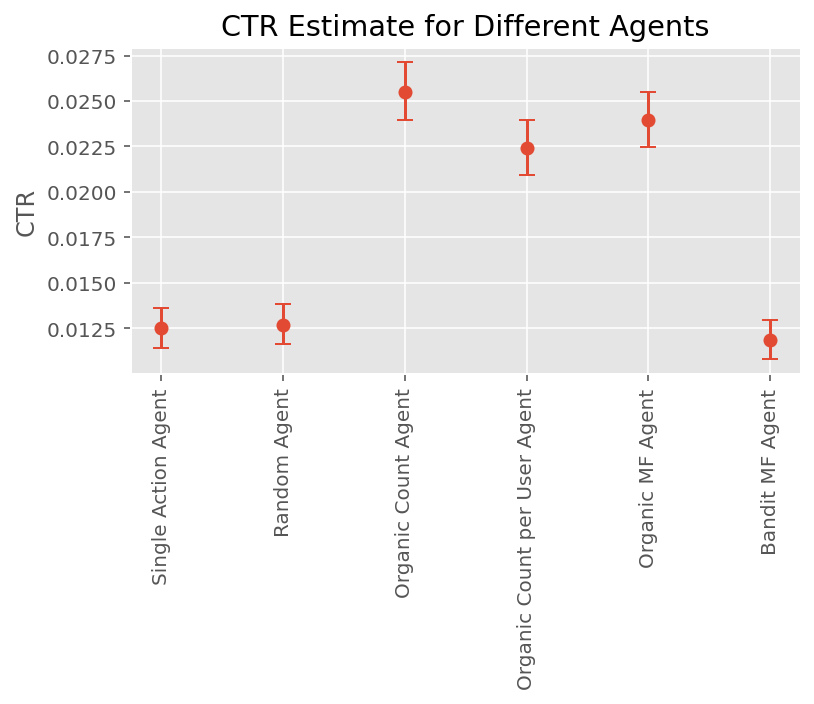

In [21]:
fig = plot_verify_agents(comb_result)
plt.ylabel('CTR')
plt.show()




